# DSPP Project: Northern Ireland Phytoplankton Analysis
Data from www.gov.uk using the 'Northern Ireland Phytoplankton Results 2020-2025' dataset from the Food Standards Agency

    ASP = Amnesic Shellfish Poisoning
    PSP = Paralytic Shellfish Poisoning
    DSP = Diarretic Shellfish Poisoning

In [1]:
## Import relevant packages
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import re
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error

Import csv dataset Northern Ireland Phytoplankton Results 2020-2025 as df (dataframes). 

Multiple surveys exported to give a history of phytplankton populations and allow for time series analysis.

In [ ]:
# Connect to Github repository for NI Phytoplankton Data 2020-2025
phytodf2025 = pd.read_csv('https://raw.githubusercontent.com/ClaudiaAlice/L6-Data-Science/refs/heads/main/2025_NIPhytoplanktonData.csv')
phytodf2024 = pd.read_csv('https://raw.githubusercontent.com/ClaudiaAlice/L6-Data-Science/refs/heads/main/2024_NIPhytoplanktonData.csv')
phytodf2023 = pd.read_csv('https://raw.githubusercontent.com/ClaudiaAlice/L6-Data-Science/refs/heads/main/2023_NIPhytoplanktonData.csv')
phytodf2022 = pd.read_csv('https://raw.githubusercontent.com/ClaudiaAlice/L6-Data-Science/refs/heads/main/2022_NIPhytoplanktonData.csv')
phytodf2021 = pd.read_csv('https://raw.githubusercontent.com/ClaudiaAlice/L6-Data-Science/refs/heads/main/2021_NIPhytoplanktonData.csv')
phytodf2020 = pd.read_csv('https://raw.githubusercontent.com/ClaudiaAlice/L6-Data-Science/refs/heads/main/2020_NIPhytoplanktonData.csv')

# View head of dataframe
phytodf2025.head()

        RepresentativeMonitoringPoints ShellfishSpecies DateOfSampling  \
Lough                                                                    
Belfast                   B1 - AFFNI55          Mussels     06/01/2020   
Belfast                   B1 - AFFNI55          Mussels     12/01/2020   
Belfast                   B1 - AFFNI55          Mussels     20/01/2020   
Belfast                   B1 - AFFNI55          Mussels     27/01/2020   
Belfast                   B1 - AFFNI55          Mussels     02/02/2020   

                   DSPAlgae            ASPAlgae            PSPAlgae Status  \
Lough                                                                        
Belfast  No harmful species  No harmful species  No harmful species   Open   
Belfast  No harmful species  No harmful species  No harmful species   Open   
Belfast  No harmful species  No harmful species  No harmful species   Open   
Belfast  No harmful species                 160  No harmful species   Open   
Belfast  No h

,Lough,RepresentativeMonitoringPoints,ShellfishSpecies,DateOfSampling,DSPAlgae,ASPAlgae,PSPAlgae,"Other (Producers of Yessotoxins, Hepatotoxins and Icthytoxic and nuisance species)",Status,Comments
0,Carlingford,C1 - AFFNI27,Mussels,25/06/2025,No harmful species observed,3480,No harmful species observed,No harmful species observed,OPEN,NaN
1,Carlingford,C11 - AFFNI84,Oysters,25/06/2025,40,3440,No harmful species observed,No harmful species observed,OPEN,NaN
2,Carlingford,"C15 - AFFNI89 - Represents C7 AFFNI73, C9 - AF...",Oysters,25/06/2025,No harmful species observed,1540,No harmful species observed,No harmful species observed,OPEN,NaN
3,Belfast,B1-AFFNI55,Mussels,24/06/2025,No harmful species observed,110800,No harmful species observed,No harmful species observed,OPEN,NaN
4,Belfast,B3 - AFFNI50,Mussels,24/06/2025,No harmful species observed,125600,No harmful species observed,No harmful species observed,OPEN,NaN


Ensure each export relates only to relevant date, ie 2025 export only contains 2025 data.

Append time series.

In [ ]:
# Before appending each data frame the representative data must be correct, i.e. 2024 survey only contains 2024 results
# 2025
phytodf2025['DateOfSampling'] = pd.to_datetime(phytodf2025['DateOfSampling'])#, format='%d/%m/%Y', dayfirst=True)
phytodf2025 = phytodf2025.loc[(phytodf2025['DateOfSampling'] >= '2025-01-01 00:00:00') & (phytodf2025['DateOfSampling'] < '2026-01-01 00:00:00')]
phytodf2025['Snapshot Date'] = '2025'

# Test to see if filter works 
max_date = phytodf2025['DateOfSampling'].max()
print(max_date)
min_date = phytodf2025['DateOfSampling'].min()
print(min_date)

# Apply to rest of datasets
## 2024
phytodf2024['DateOfSampling'] = pd.to_datetime(phytodf2024['DateOfSampling'], format='%d/%m/%Y', dayfirst=True)
phytodf2024 = phytodf2024.loc[(phytodf2024['DateOfSampling'] >= '2024-01-01 00:00:00') & (phytodf2024['DateOfSampling'] < '2025-01-01 00:00:00')]
phytodf2024['Snapshot Date'] = '2024'

## 2023
phytodf2023['DateOfSampling'] = pd.to_datetime(phytodf2023['DateOfSampling'], format='%d/%m/%Y', dayfirst=True)
phytodf2023 = phytodf2023.loc[(phytodf2023['DateOfSampling'] >= '2023-01-01 00:00:00') & (phytodf2023['DateOfSampling'] < '2024-01-01 00:00:00')]
phytodf2023['Snapshot Date'] = '2023'

## 2022
phytodf2022['DateOfSampling'] = pd.to_datetime(phytodf2022['DateOfSampling'], format='%d/%m/%Y', dayfirst=True)
phytodf2022 = phytodf2022.loc[(phytodf2022['DateOfSampling'] >= '2022-01-01 00:00:00') & (phytodf2022['DateOfSampling'] < '2023-01-01 00:00:00')]
phytodf2022['Snapshot Date'] = '2022'

## 2021
phytodf2021['DateOfSampling'] = pd.to_datetime(phytodf2021['DateOfSampling'], format='%d/%m/%Y', dayfirst=True)
phytodf2021 = phytodf2021.loc[(phytodf2021['DateOfSampling'] >= '2021-01-01 00:00:00') & (phytodf2021['DateOfSampling'] < '2022-01-01 00:00:00')]
phytodf2021['Snapshot Date'] = '2021'

## 2020
phytodf2020['DateOfSampling'] = pd.to_datetime(phytodf2020['DateOfSampling'], format='%d/%m/%Y', dayfirst=True)
phytodf2020 = phytodf2020.loc[(phytodf2020['DateOfSampling'] >= '2020-01-01 00:00:00') & (phytodf2020['DateOfSampling'] < '2021-01-01 00:00:00')]
phytodf2020['Snapshot Date'] = '2020'

# Append results
phytodf = pd.concat([phytodf2020, phytodf2021, phytodf2022, phytodf2023, phytodf2024, phytodf2025], ignore_index=True)

print(phytodf2025['Snapshot Date'].describe)

2025-06-25 00:00:00
2025-01-06 00:00:00
<bound method NDFrame.describe of 0      2025
1      2025
2      2025
3      2025
4      2025
       ... 
163    2025
164    2025
165    2025
166    2025
167    2025
Name: Snapshot Date, Length: 168, dtype: object>


C:\Users\claud\AppData\Local\Temp\ipykernel_18068\4096133542.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  phytodf2025['DateOfSampling'] = pd.to_datetime(phytodf2025['DateOfSampling'])#, format='%d/%m/%Y', dayfirst=True)


### Exploratory Analysis and Data Cleansing

In [ ]:
print('Data frame size:\n', phytodf.size,
      '\n\nColumn Data Types:\n',phytodf.dtypes,
      '\n\n',phytodf['Lough'].value_counts(),
      '\n Species \n', phytodf['ShellfishSpecies'].value_counts(),

      '\n Status \n', phytodf['Status'].value_counts(),
      '\n DSPAlgae \n', phytodf['DSPAlgae'].value_counts(),
      '\n Comments \n', phytodf['Comments'].value_counts()
)

Data frame size:
 23254 

Column Data Types:
 Lough                                                                                         object
RepresentativeMonitoringPoints                                                                object
ShellfishSpecies                                                                              object
DateOfSampling                                                                        datetime64[ns]
DSPAlgae                                                                                      object
ASPAlgae                                                                                      object
PSPAlgae                                                                                      object
Status                                                                                        object
Comments                                                                                      object
Snapshot Date                                

*detail of data here *

### Data Transformation

In [ ]:
# Remove blank rows
phytodf.dropna(how='all')

# # Remove 'Comments' and 'Other' Column using indexing
phytodf.drop(phytodf.columns[-1], axis=1, inplace=True)
phytodf.drop(phytodf.columns[-2], axis=1, inplace=True)

# # Rename Columns
phytodf.rename(columns={ 'Lough':'Location', 
                    'RepresentativeMonitoringPoints':'Sampling Point',
                    'ShellfishSpecies':'Species',
                    'DateOfSampling':'Date',
                    'DSPAlgae':'DSP Algae',
                    'ASPAlgae':'ASP Algae',
                    'PSPAlgae':'PSP Algae',
                    'Snapshot Date':'Snapshot Date'
                    }, inplace=True)

# Trim text columns
phytodf = phytodf.astype(str)
phytodf = phytodf.applymap(lambda x: x.rstrip() if isinstance(x, str) else x)

# # Replace Values 
phytodf = phytodf.replace('No harmful species observed', 0)
phytodf = phytodf.replace('NO harmful species observed', 0)
phytodf = phytodf.replace('no harmful species observed', 0)
phytodf = phytodf.replace('nan', 0)
phytodf = phytodf.replace('No harmful species identified', 0)
phytodf = phytodf.replace('No harmful species', 0)
phytodf = phytodf.replace('no harmful species', 0)
phytodf = phytodf.replace('Oysters / Mussels', 'Oysters/Mussels')
phytodf = phytodf.replace('Mussels/ Oysters', 'Oysters/Mussels')
phytodf = phytodf.replace('Carliingford', 'Carlingford')
phytodf = phytodf.replace('Dundrum BAY', 'Dundrum Bay')
phytodf = phytodf.replace('Dundrum BAY', 'Dundrum Bay')

# Assign Data types
phytodf = phytodf.astype({'Location':str, 
             'Sampling Point':str,
             'Species':str,
             'Date':str,
             'Status':str,
             'DSP Algae':int,
             'ASP Algae':int,
             'PSP Algae':int,
             'Snapshot Date':int
             })

# Replace values in Status column - variations of open using regex \b to match entire word
def replace_open(text, word, replacement):
    return re.sub(rf'\b{word}\b', replacement, text, flags=re.IGNORECASE)

phytodf['Status'] = phytodf['Status'].apply(lambda x: replace_open(x, 'open', 'Open'))

# Create month year column
phytodf['Date'] = pd.to_datetime(phytodf['Date'])
phytodf['Date_fday'] = '01'
phytodf['Date_MY'] = phytodf['Date_fday'] + '-' + phytodf['Date'].dt.strftime('%m-%Y')
phytodf['Date_MY'] = pd.to_datetime(phytodf['Date_MY'],dayfirst=True)  

print(
    'ASP Algae \n', phytodf['ASP Algae'].describe(),
    '\n--- \nDSP Algae \n', phytodf['DSP Algae'].describe(),
    '\n--- \nPSP Algae \n', phytodf['PSP Algae'].describe()
    )

phytodf.info()

C:\Users\claud\AppData\Local\Temp\ipykernel_18068\109297796.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  phytodf = phytodf.applymap(lambda x: x.rstrip() if isinstance(x, str) else x)


ASP Algae 
 count      2114.000000
mean       1614.858089
std       12910.164678
min           0.000000
25%           0.000000
50%           0.000000
75%         407.500000
max      494400.000000
Name: ASP Algae, dtype: float64 
--- 
DSP Algae 
 count    2114.000000
mean        9.829707
std        59.115338
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1100.000000
Name: DSP Algae, dtype: float64 
--- 
PSP Algae 
 count    2114.000000
mean        1.267739
std        22.404052
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       680.000000
Name: PSP Algae, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Location        2114 non-null   object        
 1   Sampling Point  2114 non-null   object        
 2   Species         

### Analysis - Plotting Algal distribution by location, agal species and shellfish type

#### * Key Stats

In [ ]:
# Sum all aglae as a new column
phytodf['All Algae'] = phytodf['PSP Algae'] + phytodf['ASP Algae'] + phytodf['DSP Algae'] 

# split by locations - create a data frame for each
phytodfC = phytodf.loc[phytodf['Location'] == "Carlingford"]
phytodfB = phytodf.loc[phytodf['Location'] == "Belfast"]
phytodfS = phytodf.loc[phytodf['Location'] == "Strangford"]
phytodfLF = phytodf.loc[phytodf['Location'] == "Lough Foyle"]
phytodfDB = phytodf.loc[phytodf['Location'] == "Dundrum Bay"]
phytodfK = phytodf.loc[phytodf['Location'] == "Killough"]
phytodfLL = phytodf.loc[phytodf['Location'] == "Larne Lough"]

# Create a dictionary and define labels
dataframes = {
    'All': phytodf,
    'Carlingford': phytodfC,
    'Belfast': phytodfB,
    'Strangford': phytodfS,
    'Lough Foyle': phytodfLF,
    'Dundrum Bay': phytodfDB,
    'Killough': phytodfK,
    'Larne Lough': phytodfLL
}

# create empty dictionaries
means = {}
median = {}
vcounts = {}
sumAllphyto = {}
sumPSPphyto = {}
sumDSPphyto = {}
sumASPphyto = {}

# load data into dictionaries for use
for location, df in dataframes.items():
    means[location] = np.mean(df['All Algae']) if not np.isnan(np.mean(df['All Algae'])) else 0
    median[location] = np.median(df['All Algae'])
    sumAllphyto[location] = df.groupby('Location')['All Algae'].sum()
    sumPSPphyto[location] = df.groupby('Location')['PSP Algae'].sum()
    sumDSPphyto[location] = df.groupby('Location')['DSP Algae'].sum()
    sumASPphyto[location] = df.groupby('Location')['ASP Algae'].sum()
    vcounts[location] = df['Species'].value_counts()

# Printing data dictionaries
for location in dataframes.keys():
    print('All Algae:')
    print(f'Means \n {location}: {means[location]:.2f}')
    print(f'Medians \n {location}: {median[location]:.2f}')
    print(f'ValueCounts \n {location}: {vcounts[location]}')
    print(f'sum \n {location}: {sumAllphyto[location]}')
    print("===================")

All Algae:
Means 
 All: 1625.96
Medians 
 All: 0.00
ValueCounts 
 All: Species
Mussels            988
Oysters            848
Oysters/Mussels    278
Name: count, dtype: int64
sum 
 All: Location
Belfast        1704610
Carlingford     301660
Dundrum Bay     348900
Killough        317180
Larne Lough      41980
Lough Foyle     532980
Strangford      189960
Name: All Algae, dtype: int64
All Algae:
Means 
 Carlingford: 467.69
Medians 
 Carlingford: 0.00
ValueCounts 
 Carlingford: Species
Oysters    389
Mussels    256
Name: count, dtype: int64
sum 
 Carlingford: Location
Carlingford    301660
Name: All Algae, dtype: int64
All Algae:
Means 
 Belfast: 2899.00
Medians 
 Belfast: 200.00
ValueCounts 
 Belfast: Species
Mussels    588
Name: count, dtype: int64
sum 
 Belfast: Location
Belfast    1704610
Name: All Algae, dtype: int64
All Algae:
Means 
 Strangford: 693.28
Medians 
 Strangford: 0.00
ValueCounts 
 Strangford: Species
Mussels            144
Oysters             90
Oysters/Mussels     40
Na

### Visualise distribution

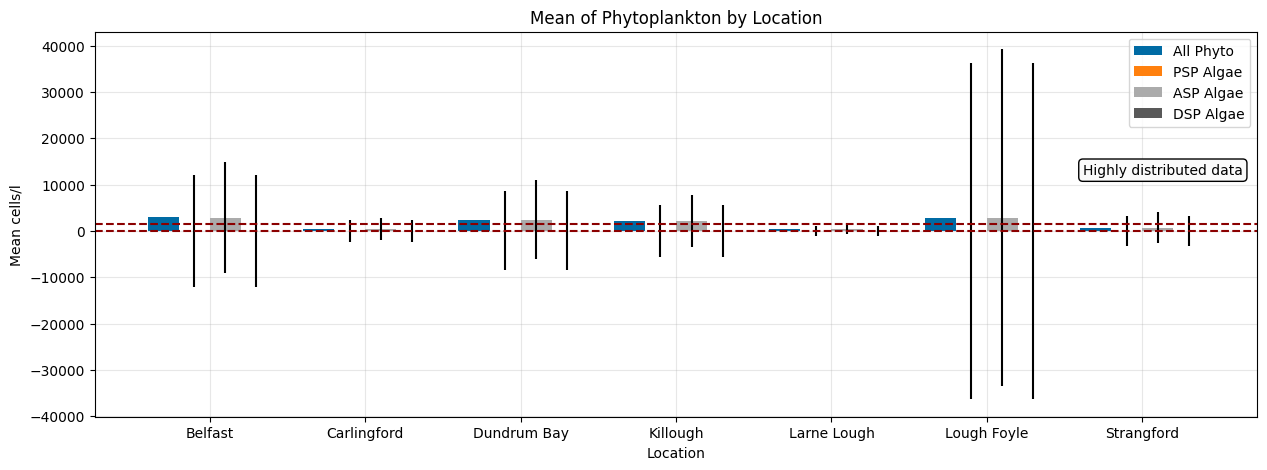

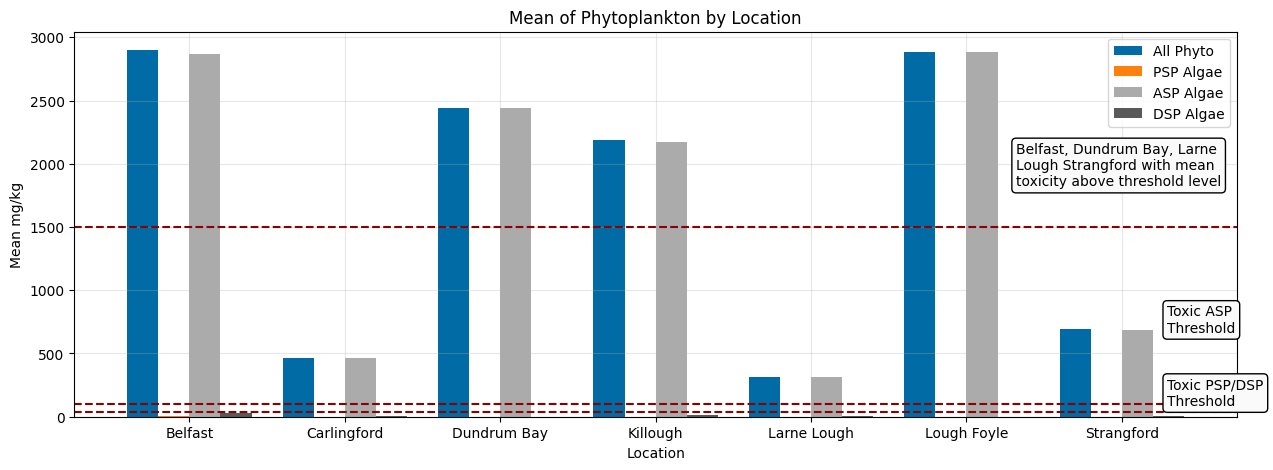

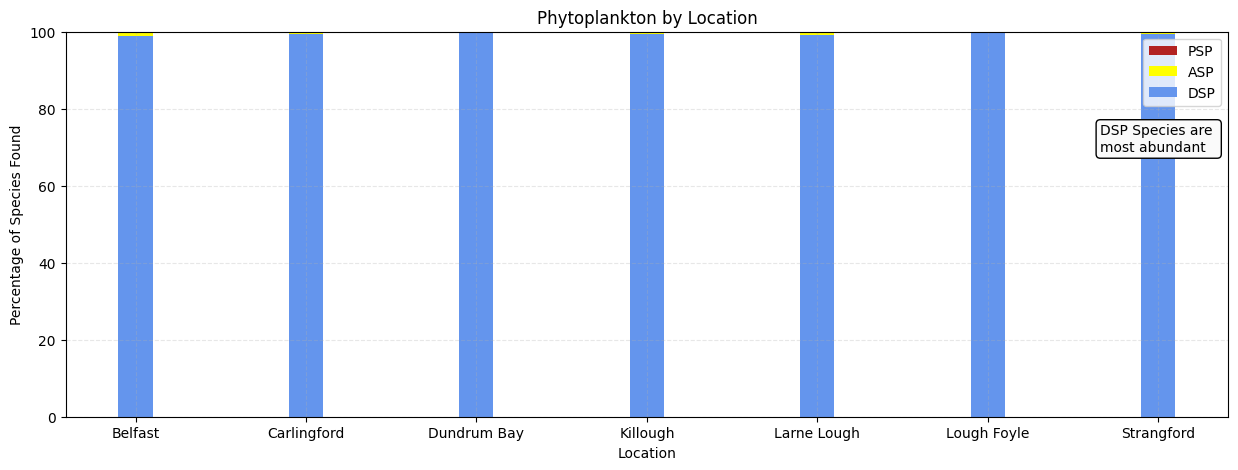

In [ ]:
#Plotting mean and standard deviation of Algae by Location and Algal type
xlabels = phytodf['Location'].unique()
yall = phytodf.groupby('Location')['All Algae'].mean()
ypsp = phytodf.groupby('Location')['PSP Algae'].mean()
yasp = phytodf.groupby('Location')['ASP Algae'].mean()
ydsp = phytodf.groupby('Location')['DSP Algae'].mean()
sasp = phytodf['ASP Algae'].groupby(phytodf['Location']).std()
sdsp = phytodf['ASP Algae'].groupby(phytodf['Location']).std()
spsp = phytodf['ASP Algae'].groupby(phytodf['Location']).std()
tpsp = 40
tasp = 1500
tdsp = 100
plt.figure(figsize=(15,5))
x_axis = np.arange(len(xlabels))
plt.bar(x_axis - 0.3, yall, label='All Phyto', width=0.2)
plt.bar(x_axis - 0.1, ypsp, yerr=spsp, label='PSP Algae', width=0.2) 
plt.bar(x_axis + 0.1, yasp, yerr=sasp, label='ASP Algae', width=0.2) 
plt.bar(x_axis + 0.3, ydsp, yerr=sdsp, label='DSP Algae', width=0.2)
plt.axhline(tpsp, linestyle='--', color='darkred')
plt.axhline(tasp, linestyle='--', color='darkred')
plt.xticks(x_axis, xlabels)
plt.style.use('tableau-colorblind10')
plt.annotate('Highly distributed data',
            xy=(2, 1), xycoords='data',
            xytext=(0.85, 0.63), textcoords='axes fraction',
            bbox=dict(boxstyle="round", fc="0.98"))
plt.grid(True, alpha=0.3, )
plt.xlabel('Location', size=10)
plt.ylabel('Mean cells/l', size=10)
plt.title('Mean of Phytoplankton by Location')
plt.legend()
plt.show() 

# Plotting distribution of algal species by location
plt.figure(figsize=(15,5))
plt.bar(x_axis - 0.3, yall, label='All Phyto', width=0.2)
plt.bar(x_axis - 0.1, ypsp, label='PSP Algae', width=0.2) 
plt.bar(x_axis + 0.1, yasp, label='ASP Algae', width=0.2) 
plt.bar(x_axis + 0.3, ydsp, label='DSP Algae', width=0.2)
plt.axhline(tpsp, linestyle='--', color='darkred')
plt.axhline(tasp, linestyle='--', color='darkred')
plt.axhline(tdsp, linestyle='--', color='darkred')
plt.xticks(x_axis, xlabels)
plt.style.use('tableau-colorblind10')
plt.annotate('Belfast, Dundrum Bay, Larne\nLough Strangford with mean\ntoxicity above threshold level',
            xy=(2, 1), xycoords='data',
            xytext=(0.81, 0.6), textcoords='axes fraction',
            bbox=dict(boxstyle="round", fc="0.98"))
plt.annotate('Toxic ASP\nThreshold',
            xy=(2, 1), xycoords='data',
            xytext=(0.94, 0.22), textcoords='axes fraction',
            bbox=dict(boxstyle="round", fc="0.98"))
plt.annotate('Toxic PSP/DSP\nThreshold',
            xy=(2, 1), xycoords='data',
            xytext=(0.94, 0.03), textcoords='axes fraction',
            bbox=dict(boxstyle="round", fc="0.98"))
plt.grid(True, alpha=0.3, )
plt.xlabel('Location', size=10)
plt.ylabel('Mean mg/kg', size=10)
plt.title('Mean of Phytoplankton by Location')
plt.legend()
plt.show() 

# Plot distribution as a percentage of total phytoplankton by location
# Creating the empty dictionaries
perc_phytoPSP = {}
perc_phytoASP = {}
perc_phytoDSP = {}

# loading standardised data into empty dictionaries
for location, df in dataframes.items():
    perc_phytoPSP[location] = (sumPSPphyto[location] / sumAllphyto[location] ) *100
    perc_phytoASP[location] = (sumASPphyto[location] / sumAllphyto[location] ) *100
    perc_phytoDSP[location] = (sumDSPphyto[location] / sumAllphyto[location] ) *100

# Create index mapping for each location
index = {'Belfast': 1, 'Carlingford': 2, 'Dundrum Bay': 3, 'Killough': 4, 'Larne Lough': 5, 'Lough Foyle': 6, 'Strangford': 7}

# Plot stacked bar plot
plt.figure(figsize=(15,5))
for location in dataframes.keys():
    if location != 'All':
        plt.bar(index[location], perc_phytoPSP[location], bottom=perc_phytoDSP[location], width=0.2, align='center', color='firebrick')
        plt.bar(index[location], perc_phytoDSP[location], bottom=perc_phytoASP[location], width=0.2, align='center', color='yellow')
        plt.bar(index[location], perc_phytoASP[location], width=0.2, align='center', color='cornflowerblue')
    else:
        None
plt.xticks([1, 2, 3, 4, 5, 6, 7],['Belfast', 'Carlingford', 'Dundrum Bay', 'Killough', 'Larne Lough', 'Lough Foyle', 'Strangford'])
plt.annotate('DSP Species are \nmost abundant',
            xy=(2, 1), xycoords='data',
            xytext=(0.89, 0.69), textcoords='axes fraction',
            bbox=dict(boxstyle="round", fc="0.98"))
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Location', size=10)
plt.ylabel('Percentage of Species Found', size=10)
plt.title('Phytoplankton by Location')
plt.legend(['PSP', 'ASP', 'DSP'])
plt.show() 

# Timeseries plot and handling of outliers
### Group by all species to analyse all NI algal populations due to skewed data towards DSP species

494400.0


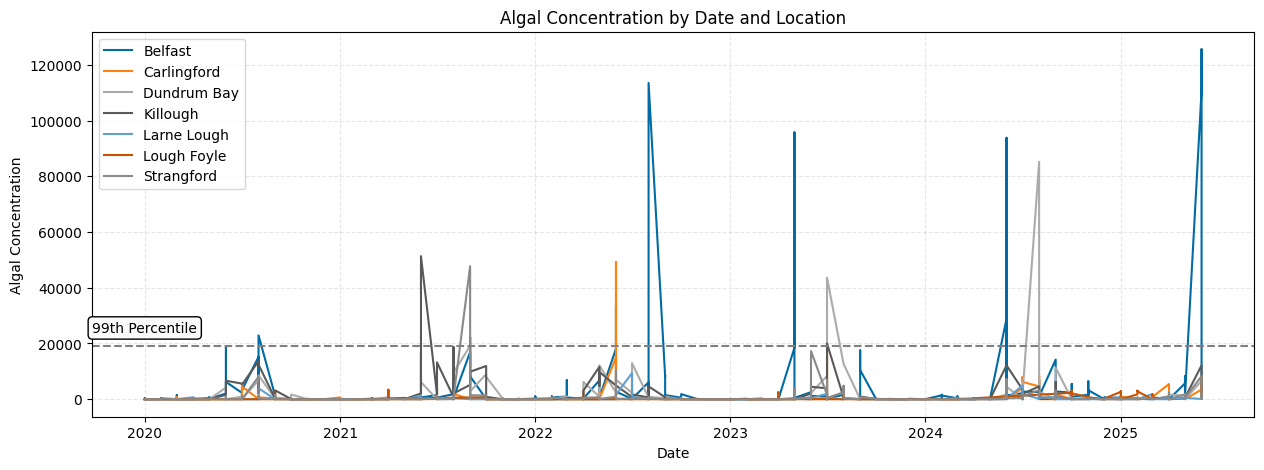

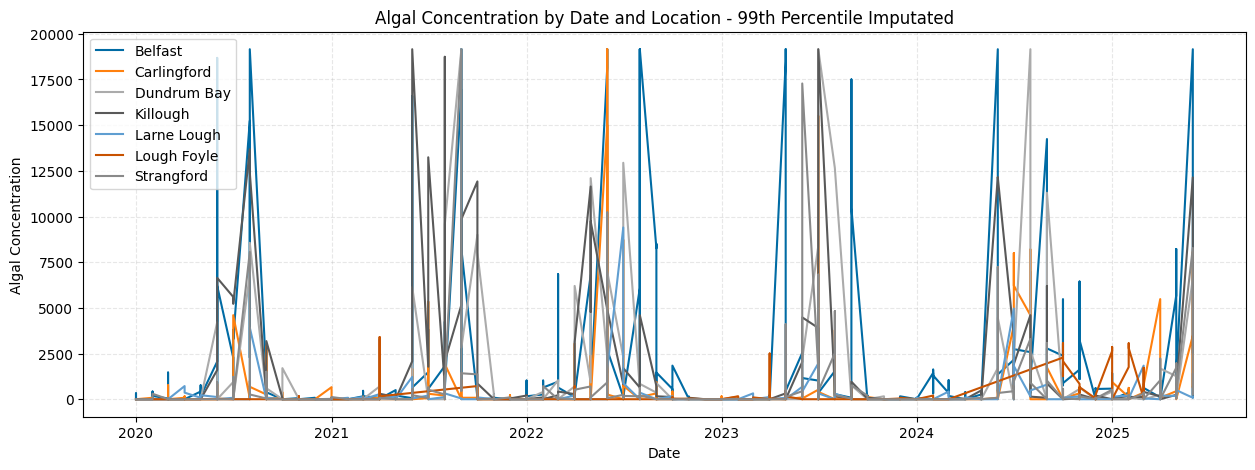

In [ ]:
# Sort by Date_MY
phytodf = phytodf.sort_values(by='Date_MY')

# Create 100th percentile for use in Larne Foyle anomaly imputation
percentile_100 = np.percentile(phytodf['All Algae'], 100)
print(percentile_100)

# Impute Larne Foyle anomaly through use of previous month rolling 3 month average
phytodf['3_month_avg'] = phytodf['All Algae'].rolling(window=3).mean()
phytodf.loc[phytodf['All Algae'] == percentile_100, 'All Algae'] = phytodf['3_month_avg'].shift(1)

# Create 99th percentile for identification of outliers
percentile_99 = np.percentile(phytodf['All Algae'], 99)

# Plot algal concentrations over time by location grouped by algal type to see outliers
grouped = phytodf.groupby('Location')
plt.figure(figsize=(15,5))
for name, group in grouped:
    plt.plot(group['Date_MY'], group['All Algae'], label=name)
plt.axhline( percentile_99, linestyle='--', color='grey')
plt.annotate('99th Percentile',
             (phytodf['Date_MY'].iloc[1], percentile_99),
             textcoords="offset points", xytext=(0,10), ha='center',
             bbox=dict(boxstyle="round", fc="0.98")
            )
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Date', size=10)
plt.ylabel('Algal Concentration', size=10)
plt.title('Algal Concentration by Date and Location')
plt.show() 


# Impute outliers above 99th percentile to be equal to 99th percentile value
phytodf['All Algae'] = np.where(phytodf['All Algae'] > percentile_99, percentile_99, phytodf['All Algae'])

# Plot transformed data by location grouped by algal type
grouped = phytodf.groupby('Location')
plt.figure(figsize=(15,5))
for name, group in grouped:
    plt.plot(group['Date_MY'], group['All Algae'], label=name)
#plt.axhline( percentile_95, linestyle='--', color='grey')
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Date', size=10)
plt.ylabel('Algal Concentration', size=10)
plt.title('Algal Concentration by Date and Location - 99th Percentile Imputated')
plt.show() 

### Take mean of all algal concentration by date to remove duplicate values for use in timeseries forecasting

['Belfast' 'Carlingford' 'Strangford' 'Dundrum Bay' 'Lough Foyle'
 'Killough' 'Larne Lough']


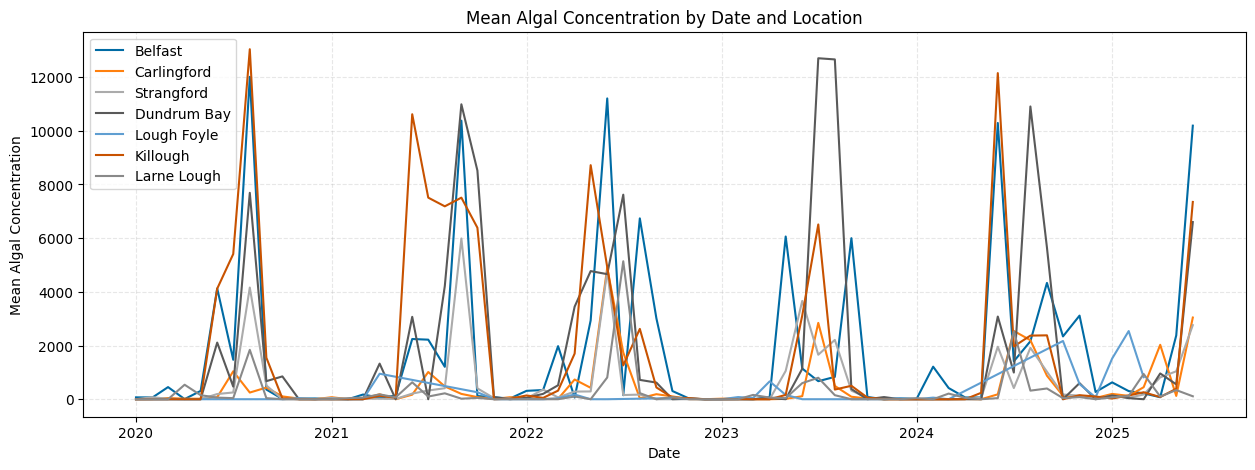

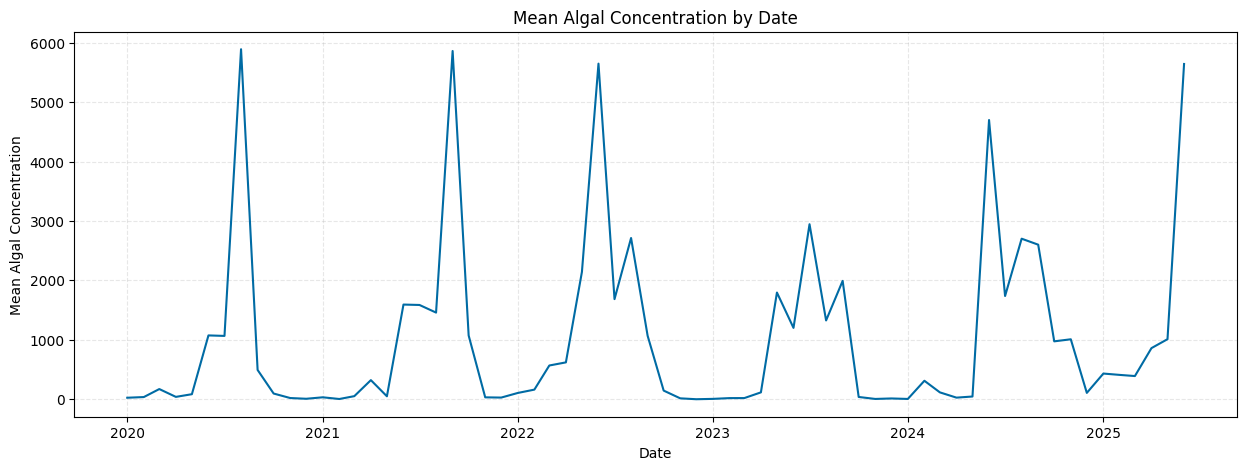

In [ ]:
# Plot Mean Algal Concentration by Location and Date
locations = phytodf['Location'].unique()
print(locations)
plt.figure(figsize=(15,5))
for location in locations:
    subset = phytodf[phytodf['Location'] == location]
    subsetmeans = subset.groupby('Date_MY')['All Algae'].mean()
    plt.plot(subset['Date_MY'].unique(), subsetmeans.values, label=f'{location}')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Date', size=10)
plt.ylabel('Mean Algal Concentration', size=10)
plt.title('Mean Algal Concentration by Date and Location')
plt.legend() 
plt.show() 

# Group phytodf by location by taking of all algae for all locations
dfmeanall = phytodf.groupby('Date_MY')['All Algae'].mean().reset_index()

# Plot Mean Algal Concentration by Date
plt.figure(figsize=(15,5))
plt.plot(phytodf['Date_MY'].unique(), dfmeanall['All Algae'].values)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Date', size=10)
plt.ylabel('Mean Algal Concentration', size=10)
plt.title('Mean Algal Concentration by Date')
plt.show() 

# Applying Timeseries Forecast - SARIMA

In [ ]:
# Rename dfmeanall column for ease of use in model
dfmeanall.rename(columns={ 'All Algae':'algaemean'}, inplace=True)

# Set index to date column
dfmeanall = dfmeanall.set_index('Date_MY')

# View data
print(dfmeanall.head())

             algaemean
Date_MY               
2020-01-01   25.000000
2020-02-01   36.326531
2020-03-01  171.071429
2020-04-01   39.428571
2020-05-01   84.444444


### Test for stationarity

1. ADF :  -5.062712791986406
2. P-Value :  1.6652357413156887e-05
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


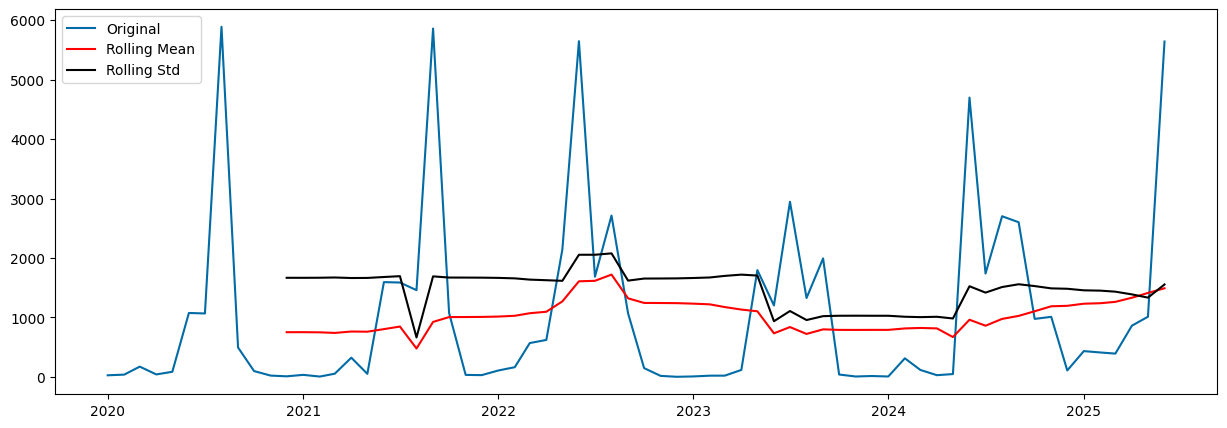

In [ ]:
# ADF test to test stationarity
dftest = adfuller(dfmeanall.algaemean, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

# Plot rolling mean and standard deviation to view stationarity
rolling_mean = dfmeanall.rolling(window=12).mean()
rolling_std = dfmeanall.rolling(window=12).std()

plt.figure(figsize=(15,5))
plt.plot(dfmeanall, label="Original")
plt.plot(rolling_mean, label="Rolling Mean", color="red")
plt.plot(rolling_std, label="Rolling Std", color="black")
plt.legend()
plt.show()

### Autocorrelation plot to help determine p, q and s values

    Autocorrelation refers to the degree of correlation of the same variables between two successive time intervals. 
    It measures how the lagged version of the value of a variable is related to the original version of it in a time series.
    lags at 6 (6 months)  damped sinusoidal wave

    autocorrelation around 0 so d = 0

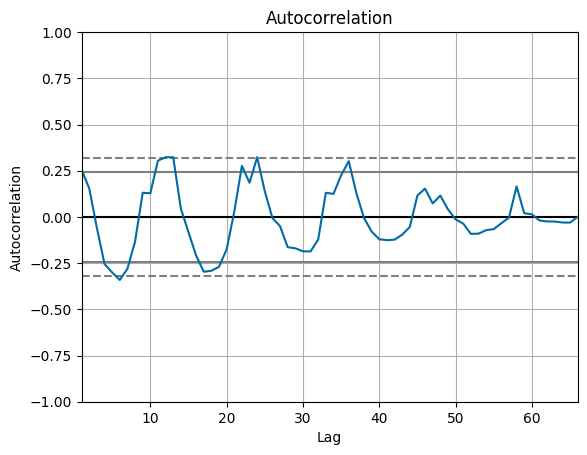

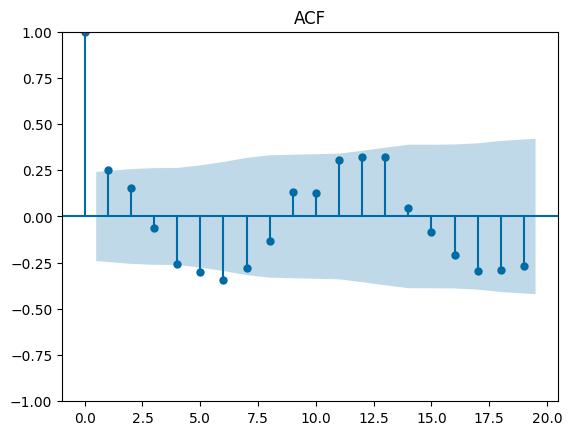

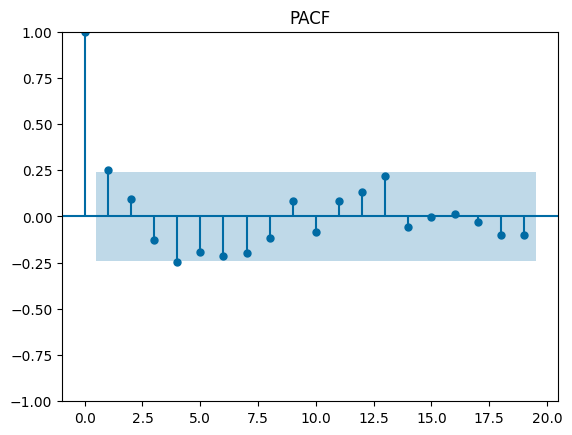

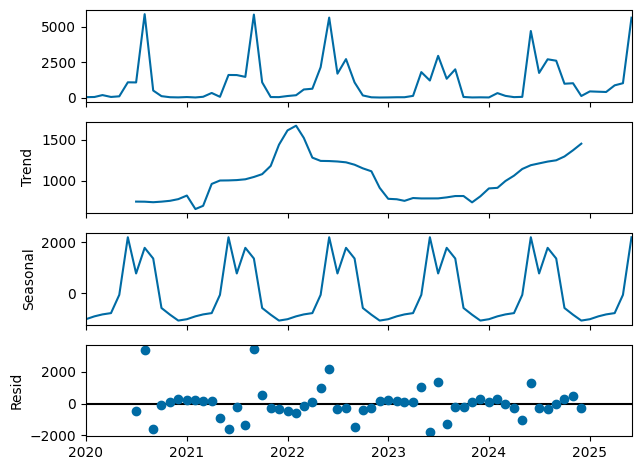

In [ ]:
# Autocorrelation plot
autocorrelation_plot(dfmeanall)
plt.title('Autocorrelation')
plt.show()

# ACF plot
plot_acf(dfmeanall)
plt.title('ACF')
plt.show()

# PACF plot
plot_pacf(dfmeanall)
plt.title('PACF')
plt.show()

# Decomposition plot
decomposition=seasonal_decompose(dfmeanall,model='additive',period=12)
decomposition.plot()
plt.show()

### Hyperparameter Optimisation

In [ ]:
# Create class for testing each of the hyperparameter combinations against assessors
class SARIMAGridSearch:
    def __init__(testing, data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values): # initialise the class
        testing.data = data
        testing.p_values = p_values
        testing.d_values = d_values
        testing.q_values = q_values
        testing.P_values = P_values
        testing.D_values = D_values
        testing.Q_values = Q_values
        testing.s_values = s_values

# Fit the SARIMA model with the initalised variables
    def fit_model(testing, order, seasonal_order):
        sarima_model = SARIMAX(testing.data, order=order, seasonal_order=seasonal_order)
        results = sarima_model.fit(disp=False) # minimise the output
        return results

# Define evaluation method
    def evaluate_model(testing, order, seasonal_order):
        results = testing.fit_model(order, seasonal_order)
        forecast = results.get_forecast(steps=12)
        forecast_mean = forecast.predicted_mean
#        forecast_mean = results.predict( start=len(testing.data), end=len(testing.data) + 11, dynamic=False)
    #    mse = mean_squared_error(testing.data[-12:], forecast_mean)
    #   return mse
        mae = mean_absolute_error(testing.data[-12:], forecast_mean)
        return mae
    #    return results.aic ## AIC results

# Perform the grid search using the various hyperparameter combinations and evaluation method
    def grid_search(testing):
        best_score, best_pdq = float("inf"), None
        param_grid = ParameterGrid({
            'p': testing.p_values,
            'd': testing.d_values,
            'q': testing.q_values,
            'P': testing.P_values,
            'D': testing.D_values,
            'Q': testing.Q_values,
            's': testing.s_values
        })
        for params in param_grid:
            order = (params['p'], params['d'], params['q'])
            seasonal_order = (params['P'], params['D'], params['Q'], params['s'])
            try:
                optimum = testing.evaluate_model(order, seasonal_order)
                if optimum < best_score: # and optimum > 11: ## Needed for AIC, difference in Work and Home Jupyter kernels due to Python versions
                    best_score, best_pdq = optimum, (order, seasonal_order)
            except:
                continue
        print(f'Best SARIMA{best_pdq[0]}x{best_pdq[1]} with lowest AIC:{best_score}')
        return best_pdq

# Assign data and hyperparameter ranges
data = pd.Series(dfmeanall['algaemean'])
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]
s_values = [12, 13]

# Return best hyperparameter comination
sarima_search = SARIMAGridSearch(data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values)
best_order, best_seasonal_order = sarima_search.grid_search()

c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\L

Best SARIMA(0, 0, 0)x(0, 1, 0, 12) with lowest AIC:1.0066022089934752e-13


c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# The hyperparameter optimisation was performed 3 times with 3 different evaluation methods; AIC, MAE and MSE
### The outcome of the three models were:

    AIC: Best SARIMA(0, 1, 1)x(0, 1, 2, 12) with lowest AIC:911.0409793990797
    MAE: Best SARIMA(0, 0, 0)x(0, 1, 0, 12) with lowest MAE:1.0066022089934752e-13
    MSE: Best SARIMA(0, 0, 0)x(0, 1, 0, 12) with lowest MSE:2.6135487697242267e-26

#### Best AIC model

c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

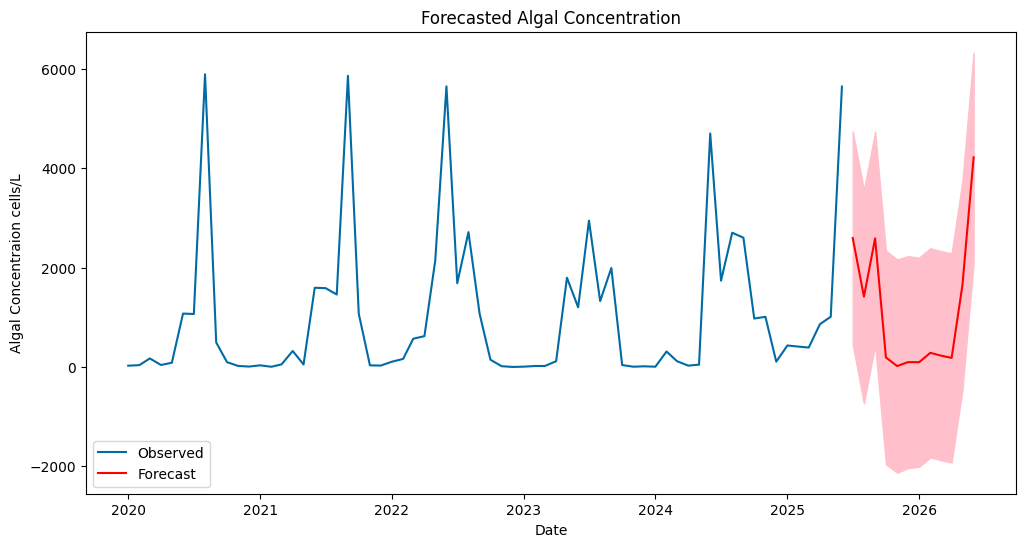

                                        SARIMAX Results                                        
Dep. Variable:                               algaemean   No. Observations:                   66
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -451.520
Date:                                 Wed, 27 Aug 2025   AIC                            911.041
Time:                                         01:29:31   BIC                            918.922
Sample:                                     01-01-2020   HQIC                           914.072
                                          - 06-01-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9992      0.268     -3.732      0.000      -1.524      -0

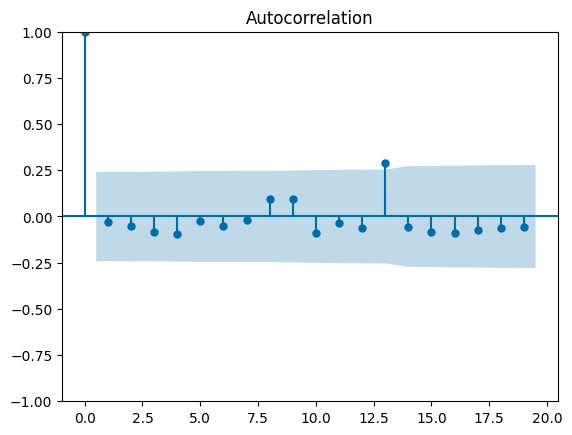

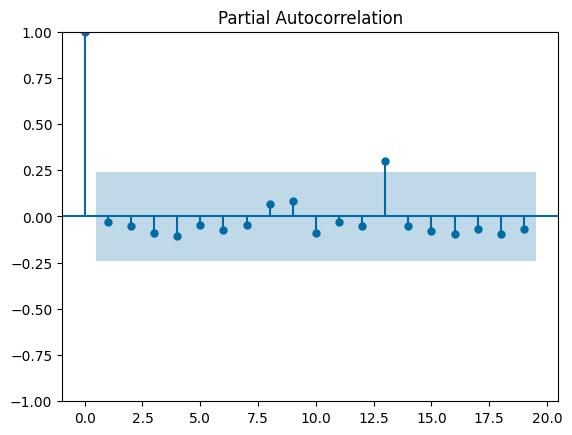

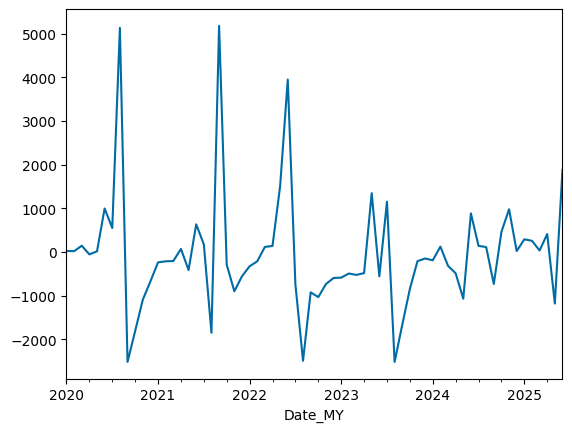

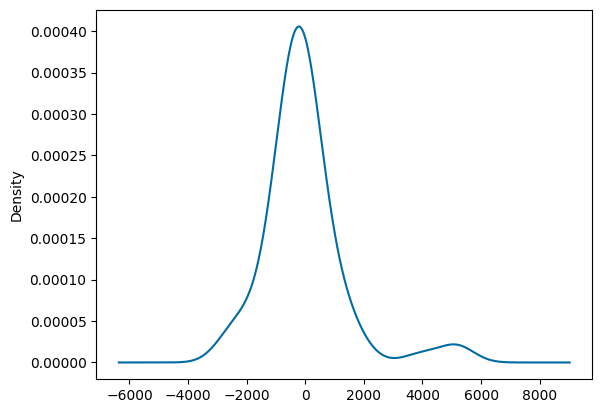

MAE: 608.5712919383205
MSE: 586213.9253814522


In [ ]:
# Plot AIC model
model = SARIMAX(dfmeanall, order=(0, 1, 1), seasonal_order=(0, 1, 2, 12)) 
results = model.fit()

# Forecast for next 12 months
forecast_periods = 12 
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(dfmeanall, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Forecasted Algal Concentration")
plt.xlabel("Date")
plt.ylabel("Algal Concentraion cells/L")
plt.legend()
plt.show()

# Print results
print(results.summary())

# Get residuals for testing of model effectiveness
residuals = results.resid
print(residuals)

# Plot residuals as ACF and PACF
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

# Calculate MAE and MSE for testing of model effectiveness
observed = dfmeanall[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

### Best MAE model

c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


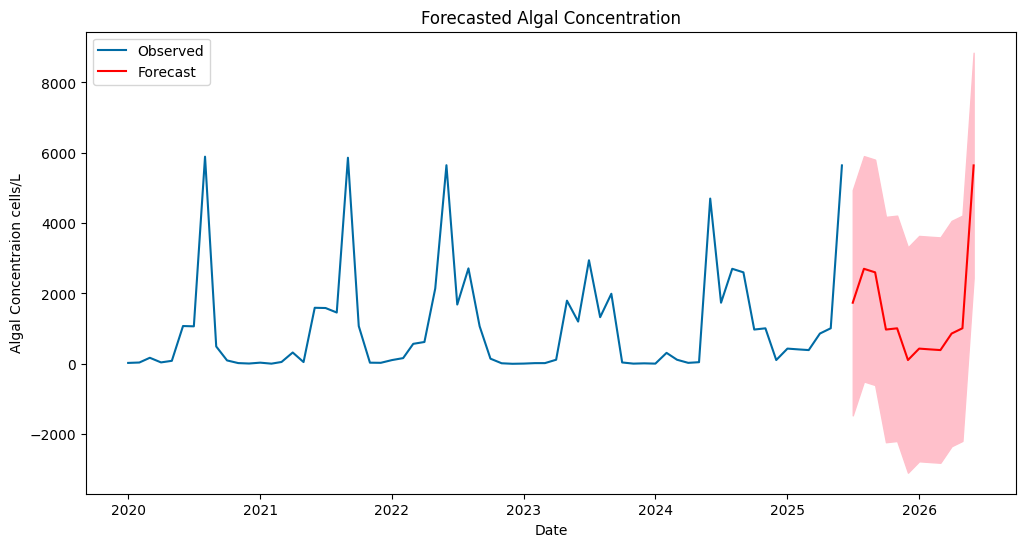

                                SARIMAX Results                                 
Dep. Variable:                algaemean   No. Observations:                   66
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -476.371
Date:                  Wed, 27 Aug 2025   AIC                            954.742
Time:                          01:29:33   BIC                            956.731
Sample:                      01-01-2020   HQIC                           955.509
                           - 06-01-2025                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.673e+06   3.04e+05      8.800      0.000    2.08e+06    3.27e+06
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                34.80
Prob(Q):                       

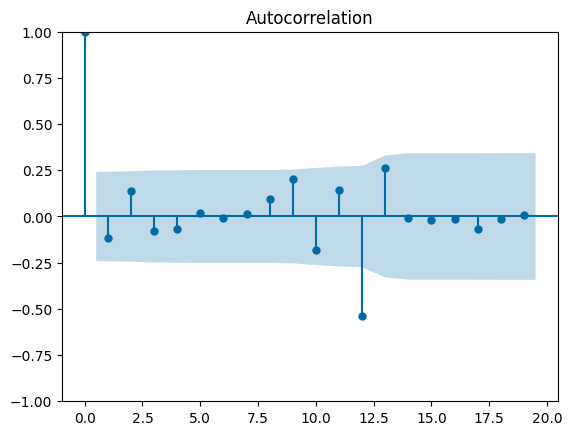

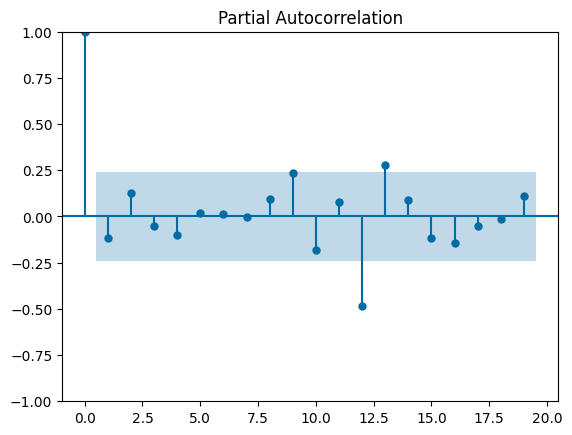

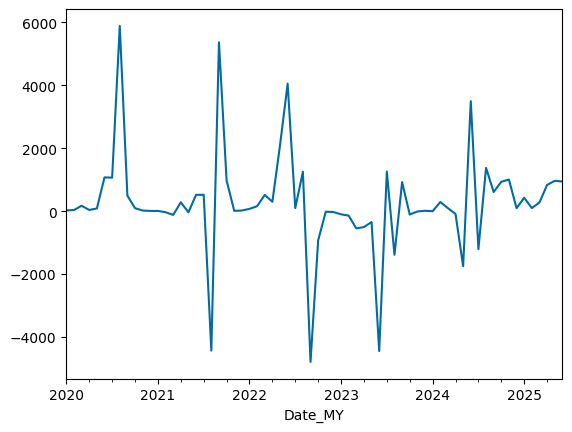

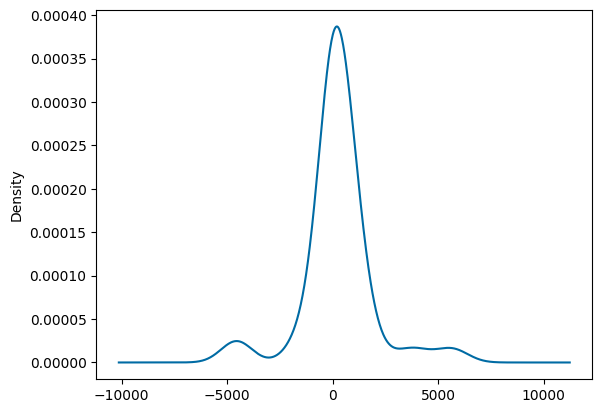

MAE: 1.0066022089934752e-13
MSE: 2.6135487697242267e-26


In [ ]:
# Plot MAE model 
model = SARIMAX(dfmeanall, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12))
results = model.fit()

# Forecast for next 12 months
forecast_periods = 12 
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(dfmeanall, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Forecasted Algal Concentration")
plt.xlabel("Date")
plt.ylabel("Algal Concentraion cells/L")
plt.legend()
plt.show()

# Print results
print(results.summary())

# Get residuals for testing of model effectiveness
residuals = results.resid
print(residuals)

# Plot residuals as ACF and PACF
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

# Calculate MAE and MSE for testing of model effectiveness
observed = dfmeanall[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

### Best MSE Model

c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\claud\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


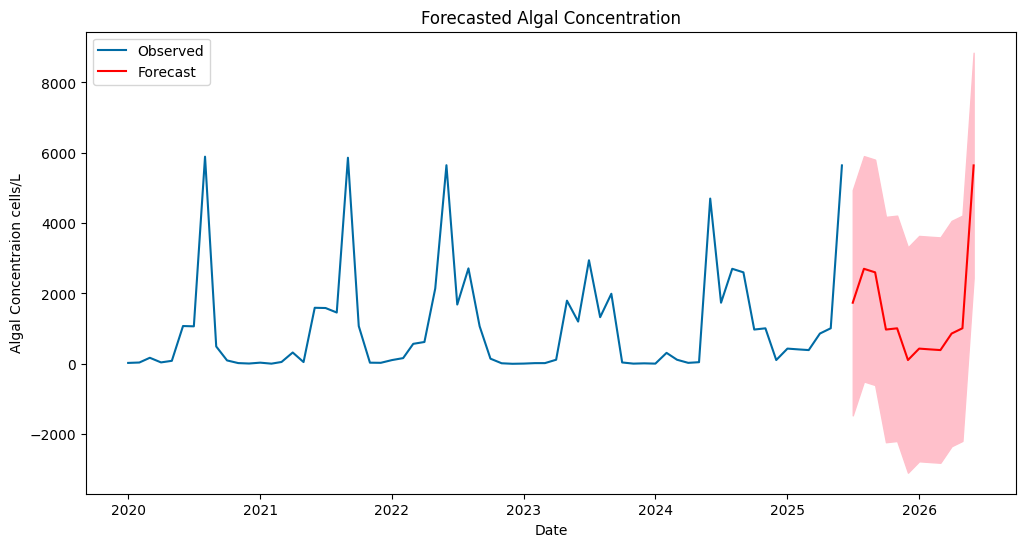

                                SARIMAX Results                                 
Dep. Variable:                algaemean   No. Observations:                   66
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -476.371
Date:                  Wed, 27 Aug 2025   AIC                            954.742
Time:                          01:29:33   BIC                            956.731
Sample:                      01-01-2020   HQIC                           955.509
                           - 06-01-2025                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.673e+06   3.04e+05      8.800      0.000    2.08e+06    3.27e+06
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                34.80
Prob(Q):                       

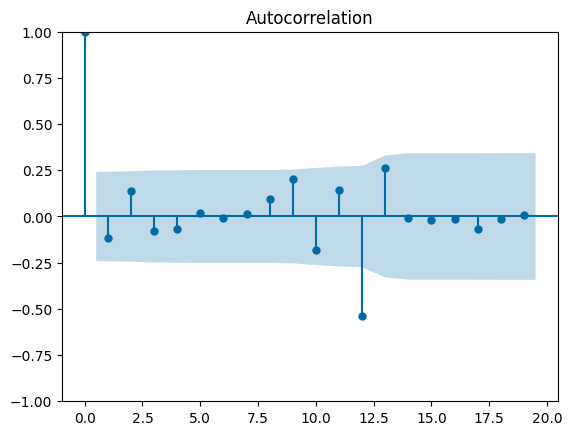

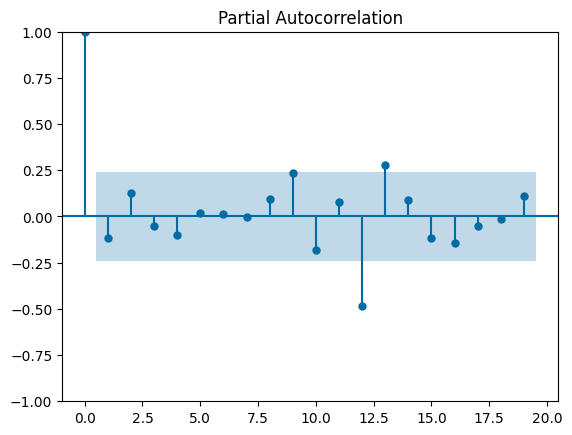

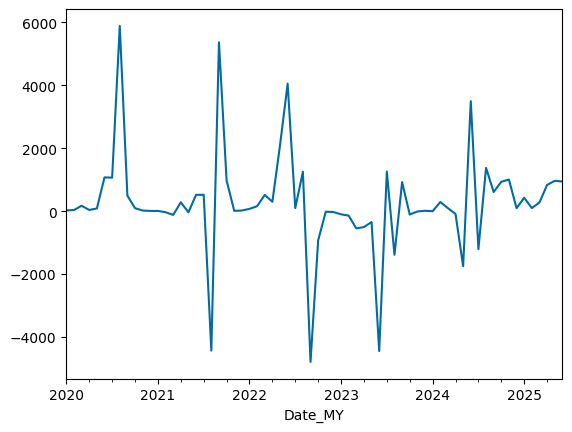

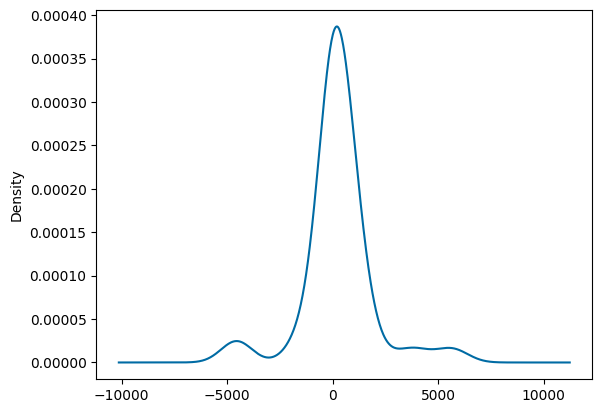

MAE: 1.0066022089934752e-13
MSE: 2.6135487697242267e-26


In [ ]:
# Plot MSE model
model = SARIMAX(dfmeanall, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12))
results = model.fit()

# Forecast for next 12 months
forecast_periods = 12 
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(dfmeanall, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Forecasted Algal Concentration")
plt.xlabel("Date")
plt.ylabel("Algal Concentraion cells/L")
plt.legend()
plt.show()

# Print results
print(results.summary())

# Get residuals for testing of model effectiveness
residuals = results.resid
print(residuals)

# Plot residuals as ACF and PACF
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

# Calculate MAE and MSE for testing of model effectiveness
observed = dfmeanall[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')